In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Predicting house prices: a regression example

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


前面两个例子都是分类问题，其目标是预测输入数据点所对应的单一离散的标签。另一种常见的机器学习问题是回归问题，它预测一个连续值而不是离散的标签，例如，根据气象数据预测明天的气温，或者根据软件说明书预测完成软件项目所需要的时间。

注意：不要将回归问题与 logistic 回归算法混为一谈。令人困惑的是，logistic 回归不是回归算法，而是分类算法。

## The Boston Housing Price dataset


本节将要预测 20 世纪 70 年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。本节用到的数据集与前面两个例子有一个有趣的区别。它包含的数据点相对较少，只有 506 个，分为 404 个训练样本和 102 个测试样本。输入数据的每个特征（比如犯罪率）都有不同的取值范围。例如，有些特性是比例，取值范围为 0~1；有的取值范围为 1~12；还有的取值范围为 0~100，等等。

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as 
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:
如你所见，我们有 404 个训练样本和 102 个测试样本，每个样本都有 13 个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。

目标是房屋价格的中位数，单位是千美元。

In [0]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13


The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not 
inflation-adjusted.

## Preparing the data


将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为 0，标准差为 1。用 Numpy 可以很容易实现标准化。

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，你不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行。

## Building our network


由于样本数量很少，我们将使用一个非常小的网络，其中包含两个隐藏层，每层有 64 个单元。一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。

In [0]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [0]:
model1 = build_model()

In [8]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________



网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将会限制输出范围。例如，如果向最后一层添加 sigmoid 激活函数，网络只能学会预测 0~1 范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。

注意，编译网络用的是 mse 损失函数，即均方误差（MSE，mean squared error），预测值与目标值之差的平方。这是回归问题常用的损失函数。

在训练过程中还监控一个新指标：平均绝对误差（MAE，mean absolute error）。它是预测值与目标值之差的绝对值。比如，如果这个问题的 MAE 等于 0.5，就表示你预测的房价与实际价格平均相差 500 美元。

## Validating our approach using K-fold validation


为了在调节网络参数（比如训练的轮数）的同时对网络进行评估，你可以将数据划分为训 练集和验证集，正如前面例子中所做的那样。但由于数据点很少，验证集会非常小（比如大约100 个样本）。因此，验证分数可能会有很大波动，这取决于你所选择的验证集和训练集。也就是说，验证集的划分方式可能会造成验证分数上有很大的方差，这样就无法对模型进行可靠的评估。 在这种情况下，最佳做法是使用 K 折交叉验证。这种方法将可用数据划分为 K 个分区（K 通常取 4 或 5），实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于 K 个验证分数的平均值

In terms of code, this is straightforward:

In [0]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    # np.concatenate    数组拼接
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    

In [0]:
all_scores

In [0]:
np.mean(all_scores)

每次运行模型得到的验证分数有很大差异，从 2.1 到 2.7 不等。平均分数（2.3）是比单一分数更可靠的指标——这就是 K 折交叉验证的关键。在这个例子中，预测的房价与实际价格平均相差 2400 美元，考虑到实际价格范围在 10 000~50 000 美元，这一差别还是很大的。

我们让训练时间更长一点，达到 500 个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [0]:
from keras import backend as K

# Some memory clean-up 清空之前model占用的内存
K.clear_session()

In [0]:
# num_epochs = 500 # 500太大，程序会直接死掉 可以改变batch_size解决
# all_mae_histories = []
# for i in range(k):
#     print('processing fold #', i)
#     # Prepare the validation data: data from partition # k 准备验证数据：第 k 个分区的数据
#     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
#     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

#     # Prepare the training data: data from all other partitions （准备训练数据：其他所有分区的数据）
#     partial_train_data = np.concatenate(
#         [train_data[:i * num_val_samples],
#          train_data[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [train_targets[:i * num_val_samples],
#          train_targets[(i + 1) * num_val_samples:]],
#         axis=0)

#     # Build the Keras model (already compiled)
#     model = build_model()
#     # Train the model (in silent mode, verbose=0)
#     history = model.fit(partial_train_data, partial_train_targets,
#                         validation_data=(val_data, val_targets),
#                         epochs=num_epochs, batch_size=1, verbose=0)
#     mae_history = history.history['val_mean_absolute_error']
#     all_mae_histories.append(mae_history)

In [0]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k（准备验证数据：第 k 个分区的数据）
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions（准备训练数据：其他所有分区的数据）
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)（构建 Keras 模型（已编译））
    model = build_model()
    # Train the model (in silent mode, verbose=0)（训练模型（静默模式，verbose=0））
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=32, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


We can then compute the average of the per-epoch MAE scores for all folds:

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this:

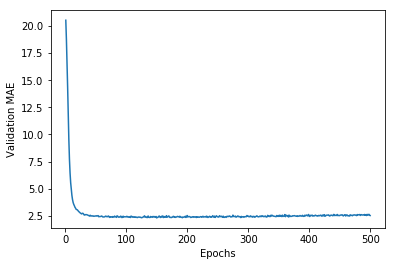

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。

* 删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。
* 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

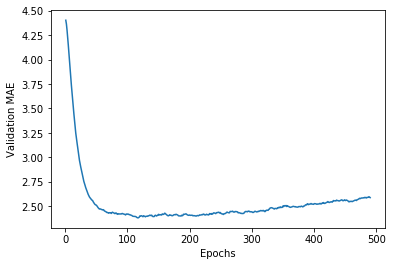

In [0]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


从图可以看出，验证 MAE 在 80 轮后不再显著降低，之后就开始过拟合。

完成模型调参之后（除了轮数，还可以调节隐藏层大小），你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。

In [0]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 886us/step


In [0]:
test_mae_score

2.7392658252342073

We are still off by about \$2,550.

## Wrapping up


下面是你应该从这个例子中学到的要点。

* 回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）。
* 同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）。
* 如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。
* 如果可用的数据很少，使用 K 折验证可以可靠地评估模型。
* 如果可用的训练数据很少，最好使用隐藏层较少（通常只有一到两个）的小型网络，以避免严重的过拟合。
在下一章中，您将获得对这些第一个示例中遇到的一些概念的更直观的理解，例如数据预处理，模型评估和过度拟合。